# Book chapter - PCA-3+K-Means++ - Full features

---



Dataset source: described on the paper

Source of the PCA implementation (number 4): https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html



# 1. Import

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from time import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics import *
import seaborn as sns
sns.set()

In [0]:
!pip install ipython-autotime

%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=aca003ce8081322c833d0820bdd9309237227711578b423c176a16617bad6182
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [0]:
from google.colab import files
uploaded = files.upload()

Saving dataset_joined.csv to dataset_joined.csv
time: 1min 31s


## Read CSV

In [0]:
df = pd.read_csv('dataset_joined.csv', sep=',', encoding = "ISO-8859-1")

time: 118 ms


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10,11,12,13,14,15,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Verify import

In [0]:
df.head()

,UniqueIDDataset,UniqueIDRow,SCLink,System,Temperature,TemperatureHumid,RelativeHumidity,WindDirection,WindVelocity,LotNumber,Acetochlor,Atrazine,Ciat,Ceat,Dimethenamid,Stage,Defoliation,Reproductive,Bolls,Height,Nodes,Weight,Yield,BatchNumber,Destination,Defective,MeanSignalStrength,StdSignalStrength,MeanLinkQuality,StdLinkQuality,MeanNoiseFloor,StdNoiseFloor,StdTemperature,StdRH,Machine,pCutTorque,pCutLagError,pCutActualPosition,pCutActualSpeed,pSvolFilmActualPosition,pSvolFilmActualSpeed,pSvolFilmLagError
0,1,1,Farm,2,24.4,22.4,84.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,Farm,2,22.9,21.5,88.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,Farm,2,26.6,23.3,75.0,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,Farm,2,22.6,21.4,89.0,36.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,5,Farm,2,22.4,21.3,90.0,36.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


time: 96.7 ms


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36351 entries, 0 to 36350
Data columns (total 42 columns):
UniqueIDDataset            36351 non-null int64
UniqueIDRow                36351 non-null int64
SCLink                     36351 non-null object
System                     36351 non-null int64
Temperature                22489 non-null float64
TemperatureHumid           19175 non-null float64
RelativeHumidity           23149 non-null float64
WindDirection              20520 non-null float64
WindVelocity               20518 non-null float64
LotNumber                  1537 non-null float64
Acetochlor                 184 non-null object
Atrazine                   184 non-null object
Ciat                       184 non-null object
Ceat                       184 non-null object
Dimethenamid               184 non-null object
Stage                      250 non-null object
Defoliation                250 non-null float64
Reproductive               250 non-null float64
Bolls                

In [0]:
df.describe()

,UniqueIDDataset,UniqueIDRow,System,Temperature,TemperatureHumid,RelativeHumidity,WindDirection,WindVelocity,LotNumber,Defoliation,Reproductive,Bolls,Height,Nodes,Weight,Yield,Destination,Defective,MeanSignalStrength,StdSignalStrength,MeanLinkQuality,StdLinkQuality,MeanNoiseFloor,StdNoiseFloor,StdTemperature,StdRH,Machine,pCutTorque,pCutLagError,pCutActualPosition,pCutActualSpeed,pSvolFilmActualPosition,pSvolFilmActualSpeed,pSvolFilmLagError
count,36351.000000,36351.000000,36351.000000,22489.000000,19175.000000,23149.000000,20520.000000,20518.000000,1537.000000,250.000000,250.000000,250.000000,250.000000,250.000000,125.000000,432.00000,671.000000,465.000000,1998.000000,1999.000000,1998.000000,1998.000000,1998.000000,1997.000000,1998.000000,1998.000000,14287.000000,12288.000000,12288.000000,12288.000000,12288.000000,12288.000000,12288.000000,12288.000000
mean,3.431487,7938.134384,2.398393,24.040672,19.498154,62.482943,15.553655,1.993545,105.464541,50.000000,4.112000,3.912000,69.224000,14.908000,25.779840,496.11331,1.527571,14.532129,-86.147292,2.796471,96.946765,20.736383,-95.416907,36.649044,0.022839,0.055271,3.780150,-0.113236,0.000012,-835919.878337,886.997007,46516.192464,1373.244194,0.634156
std,2.840264,5779.083632,0.525929,4.256546,2.763787,21.374480,12.488792,1.650432,106.291708,35.426263,1.149234,1.292648,8.276947,1.761804,6.831864,415.67746,0.499612,6.041447,10.161517,16.187693,3.717591,17.168584,3.078773,86.948962,0.040996,0.262014,2.035875,0.408600,0.038929,29288.666806,1295.032421,32570.780305,631.174696,0.114129
min,1.000000,1.000000,1.000000,8.400000,1.700000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,43.000000,10.000000,4.735000,10.17000,1.000000,6.000000,-92.500000,0.000000,85.500000,0.585600,-109.290000,0.000000,0.004285,0.000000,1.000000,-2.843960,-0.599982,-884747.000000,-954.437256,11127.000000,-25.043488,-0.086025
25%,1.000000,2776.500000,2.000000,21.200000,17.700000,48.000000,5.000000,1.000000,30.000000,25.000000,3.000000,3.000000,63.000000,14.000000,22.560000,182.07500,1.000000,9.700000,-89.542000,0.451390,94.525250,8.459175,-97.333000,0.421910,0.011037,0.015378,2.000000,-0.344438,-0.009893,-852347.000000,-127.029419,19583.250000,736.276001,0.610809
50%,1.000000,7320.000000,2.000000,23.500000,20.100000,64.000000,14.000000,2.000000,67.000000,50.000000,4.000000,4.000000,70.000000,15.000000,26.994000,339.88500,2.000000,13.250000,-88.752500,1.007900,97.021500,14.251500,-96.000000,4.918000,0.014945,0.020292,4.000000,-0.183299,-0.000074,-838818.000000,497.817993,35097.000000,1392.412964,0.653197
75%,7.000000,11864.000000,3.000000,27.000000,21.500000,80.000000,27.000000,3.000000,149.000000,75.000000,5.000000,5.000000,74.875000,16.000000,30.010000,728.58500,2.000000,17.800000,-88.021000,1.483000,98.872000,30.007000,-94.150250,52.381000,0.021213,0.029886,5.000000,0.292760,0.010476,-816100.500000,1991.271973,67492.750000,2003.471802,0.692448
max,7.000000,20527.000000,3.000000,38.800000,30.000000,100.000000,36.000000,17.000000,432.000000,100.000000,8.000000,8.000000,92.000000,20.000000,38.320000,2037.63000,2.000000,57.500000,-17.212000,377.350000,107.150000,168.580000,-85.082000,1867.900000,0.584290,4.739800,10.000000,0.632072,0.367500,-783498.000000,3570.556641,113597.000000,2742.251953,0.962216


time: 190 ms


# 2. Dataprep

## Transform to numbers

In [0]:
def dropColumns(data, columns):
    for col in columns:
        data = data.drop(columns=col)  
        
    return data
    
def fillNans(data, strategy):
    if strategy=='ZERO':
        data = data.fillna(0)
    elif strategy=='MIN':
        data = data.fillna(-999)
    elif strategy=='MAX':
        data = data.fillna(999)
    elif strategy=='INTER':
        data = data.interpolate(method='linear', limit_direction='backward', axis=0)
        data = data.interpolate(method='linear', limit_direction='forward', axis=0)

    return data

time: 14.8 ms


## Fix acetochlor

In [0]:
df.Acetochlor.replace(to_replace="<.05", value=0.05, inplace=True)

time: 12.9 ms


In [0]:
df["AcetocNum"] = pd.to_numeric(df['Acetochlor'])

time: 10.5 ms


## Fix stage

In [0]:
le = preprocessing.LabelEncoder()

time: 659 µs


In [0]:
df['Stage'].fillna("nan",inplace=True)

time: 7.66 ms


In [0]:
df['Stage'].unique()

array(['nan', 'vegetative', 'flowerbud', 'blossom', 'boll', 'bollopen'],
      dtype=object)

time: 14.6 ms


In [0]:
le.fit(df['Stage'])

LabelEncoder()

time: 7.73 ms


In [0]:
le.classes_

array(['blossom', 'boll', 'bollopen', 'flowerbud', 'nan', 'vegetative'],
      dtype=object)

time: 3.9 ms


In [0]:
df['StageNum'] = le.transform(df['Stage'])

time: 15.2 ms


In [0]:
df['StageNum'].unique()

array([4, 5, 3, 0, 1, 2])

time: 4.59 ms


## Fix sclink number

In [0]:
le3 = preprocessing.LabelEncoder()

time: 1.64 ms


In [0]:
df['SCLinkNum'] = le3.fit_transform(df['SCLink'])

time: 16.9 ms


In [0]:
df.head()

,UniqueIDDataset,UniqueIDRow,SCLink,System,Temperature,TemperatureHumid,RelativeHumidity,WindDirection,WindVelocity,LotNumber,Acetochlor,Atrazine,Ciat,Ceat,Dimethenamid,Stage,Defoliation,Reproductive,Bolls,Height,Nodes,Weight,Yield,BatchNumber,Destination,Defective,MeanSignalStrength,StdSignalStrength,MeanLinkQuality,StdLinkQuality,MeanNoiseFloor,StdNoiseFloor,StdTemperature,StdRH,Machine,pCutTorque,pCutLagError,pCutActualPosition,pCutActualSpeed,pSvolFilmActualPosition,pSvolFilmActualSpeed,pSvolFilmLagError,AcetocNum,StageNum,SCLinkNum
0,1,1,Farm,2,24.4,22.4,84.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,0
1,1,2,Farm,2,22.9,21.5,88.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,0
2,1,3,Farm,2,26.6,23.3,75.0,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,0
3,1,4,Farm,2,22.6,21.4,89.0,36.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,0
4,1,5,Farm,2,22.4,21.3,90.0,36.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,0


time: 107 ms


## Fix batch number

In [0]:
le2 = preprocessing.LabelEncoder()

time: 1.74 ms


In [0]:
df['BatchNumber'].fillna("nan",inplace=True)

time: 8.12 ms


In [0]:
df['BatchNumber'].unique()

array(['nan', '8553FA02', '7162EG01', '4819CJ01', '8581FK05', '5066FL01',
       '7858GP03', '1609GN01', '9566GC01', '7922GR01', '9534EO01',
       '3625CF01', '1424FK01', '378FK01', '7375CB01', '7796EK03',
       '8361EH01', '8010EJ03', '2081GA03', '3876EX01', '8728EL02',
       '1074FL01', '2344FP01', '2480FH01', '4840FR01', '6330FT02',
       '487GH01', '8438CG03', '804FK01', '9592EG01', '6960CT03',
       '3063EV01', '4643FK02', '5238FK01', '6866GL01', '1929FR03',
       '5920FF01', '2328FG03', '2203FS01', '1623FS01', '2441FP01',
       '3063EU01', '4623EZ01', '6612FJ03', '1557GC01', '2256EN01',
       '2371CE04', '8020EJ03', '3756EY01', '972FP02', '9621FL02',
       '9750FN01', '6091EH01', '5869FB01', '5691FN01', '7323FA01',
       '1423FK01', '9FE01', '2182CU03', '6312GC01', '3063GC01',
       '9275GC01', '6573GL01', '2739FL01', '2773BH01', '1437FK01',
       '1256FL01', '6392EJ01', '7066EU02', '6692CB01', '5366EQ01',
       '8581FK03', '2666FG03', '8010EJ01', '6116FP01', '7356CL

time: 9.33 ms


In [0]:
le2.fit(df['BatchNumber'])

LabelEncoder()

time: 5.28 ms


In [0]:
le2.classes_

array(['1009GS01', '1073FL01', '1073GS01', '1074FL01', '1086FK02',
       '1131FJ01', '11JG8350', '122CG01', '1256FL01', '1277GA01',
       '1379FT01', '1423FK01', '1424FK01', '142FK01', '1437FK01',
       '1440ET02', '1450FG01', '1450GU01', '1522GN01', '1557GC01',
       '15FC06', '1609GN01', '1623FS01', '1735HH07', '1740HH01',
       '1740HH07', '1757GV02', '1802FY01', '1846FG01', '1929FR03',
       '1934CK09', '1986FK01', '1987GF01', '2013GP01', '2023HH07',
       '2025HH07', '2027HH07', '2081GA03', '209FC01', '2116FG02',
       '217EJ04', '2182CU03', '2203FS01', '220FT01', '2256EN01',
       '2283EY01', '2301FS01', '2305BC01', '2325FP01', '2328FG03',
       '2341FP01', '2342FP01', '2344FP01', '2345EG01', '2371CE04',
       '2441FP01', '2455EJ01', '2473FE01', '2480FH01', '2535FP01',
       '2658AI01', '2659GP01', '2665FG01', '2665FG03', '2666FG01',
       '2666FG02', '2666FG03', '2666fg03', '269EG02', '269EJ02',
       '2739FL01', '2766FL07', '2773BH01', '2951GY01', '2984EN01',
    

time: 4.91 ms


In [0]:
df['BatchNum'] = le2.transform(df['BatchNumber'])

time: 12.1 ms


In [0]:
df['BatchNum'].unique()

array([275, 238, 190, 127, 242, 137, 214,  21, 259, 216, 258,  86,  12,
        89, 197, 210, 234, 219,  37,  93, 247,   3,  52,  58, 129, 167,
       132, 235, 223, 260, 183,  77, 122, 140, 181,  29, 155,  49,  42,
        22,  55,  76, 121, 175,  19,  44,  54, 221,  88, 265, 262, 268,
       159, 154, 150, 193,  11, 274,  41, 165,  78, 253, 174,  70,  72,
        14,   8, 170, 187, 177, 142, 241,  66, 218, 162, 195,  56, 209,
        32,  80, 217,  94, 115, 135,  20, 164, 136,  43, 246, 130,  51,
        84, 191, 194, 123, 206,  79, 248,  27, 236, 232,  71, 243, 103,
         4,  45, 254, 224, 213, 118, 188, 245,  57, 227,  81, 143, 239,
        31, 124, 173, 255, 180,  30,   6, 189, 100, 249,  97, 138, 228,
       240,   7,  68, 203, 117, 270, 178, 101, 233,  83, 147, 273,  73,
        16, 192, 120, 144,  46, 119, 146, 244, 116, 149,  62, 108, 231,
        75,  53,  74, 272,  63,   5, 215, 104, 257, 114, 182, 264,  38,
        98,  91,  48, 109, 153,  15,  82, 201, 237, 212, 269, 16

time: 6.04 ms


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36351 entries, 0 to 36350
Data columns (total 46 columns):
UniqueIDDataset            36351 non-null int64
UniqueIDRow                36351 non-null int64
SCLink                     36351 non-null object
System                     36351 non-null int64
Temperature                22489 non-null float64
TemperatureHumid           19175 non-null float64
RelativeHumidity           23149 non-null float64
WindDirection              20520 non-null float64
WindVelocity               20518 non-null float64
LotNumber                  1537 non-null float64
Acetochlor                 184 non-null object
Atrazine                   184 non-null object
Ciat                       184 non-null object
Ceat                       184 non-null object
Dimethenamid               184 non-null object
Stage                      36351 non-null object
Defoliation                250 non-null float64
Reproductive               250 non-null float64
Bolls              

## Drop text columns

In [0]:
columns = ["SCLink","UniqueIDDataset","UniqueIDRow","System","Atrazine","Ciat","Ceat","Dimethenamid","Acetochlor","Stage","BatchNumber","SCLinkNum"]
data = dropColumns(df, columns)

time: 64.4 ms


## Remove nans

In [0]:
data = fillNans(data, "ZERO")

time: 9.36 ms


In [0]:
data.head()

,Temperature,TemperatureHumid,RelativeHumidity,WindDirection,WindVelocity,LotNumber,Defoliation,Reproductive,Bolls,Height,Nodes,Weight,Yield,Destination,Defective,MeanSignalStrength,StdSignalStrength,MeanLinkQuality,StdLinkQuality,MeanNoiseFloor,StdNoiseFloor,StdTemperature,StdRH,Machine,pCutTorque,pCutLagError,pCutActualPosition,pCutActualSpeed,pSvolFilmActualPosition,pSvolFilmActualSpeed,pSvolFilmLagError,AcetocNum,StageNum,BatchNum
0,24.4,22.4,84.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,275
1,22.9,21.5,88.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,275
2,26.6,23.3,75.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,275
3,22.6,21.4,89.0,36.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,275
4,22.4,21.3,90.0,36.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,275


time: 80.7 ms


In [0]:
data.columns

Index(['Temperature', 'TemperatureHumid', 'RelativeHumidity', 'WindDirection',
       'WindVelocity', 'LotNumber', 'Defoliation', 'Reproductive', 'Bolls',
       'Height', 'Nodes', 'Weight', 'Yield', 'Destination', 'Defective',
       'MeanSignalStrength', 'StdSignalStrength', 'MeanLinkQuality',
       'StdLinkQuality', 'MeanNoiseFloor', 'StdNoiseFloor', 'StdTemperature',
       'StdRH', 'Machine', 'pCutTorque', 'pCutLagError', 'pCutActualPosition',
       'pCutActualSpeed', 'pSvolFilmActualPosition', 'pSvolFilmActualSpeed',
       'pSvolFilmLagError', 'AcetocNum', 'StageNum', 'BatchNum'],
      dtype='object')

time: 5.02 ms


## Scale data

In [0]:
scaler = StandardScaler()

time: 1.14 ms


In [0]:
data = pd.DataFrame(scaler.fit_transform(data), columns= data.columns)

time: 37.9 ms


In [0]:
data.head()

,Temperature,TemperatureHumid,RelativeHumidity,WindDirection,WindVelocity,LotNumber,Defoliation,Reproductive,Bolls,Height,Nodes,Weight,Yield,Destination,Defective,MeanSignalStrength,StdSignalStrength,MeanLinkQuality,StdLinkQuality,MeanNoiseFloor,StdNoiseFloor,StdTemperature,StdRH,Machine,pCutTorque,pCutLagError,pCutActualPosition,pCutActualSpeed,pSvolFilmActualPosition,pSvolFilmActualSpeed,pSvolFilmLagError,AcetocNum,StageNum,BatchNum
0,0.784279,1.218901,1.279492,-0.722900,-0.709612,-0.146399,-0.067868,-0.080137,-0.079004,-0.082626,-0.08264,-0.05679,-0.083894,-0.130232,-0.105027,0.239411,-0.039961,-0.240978,-0.18362,0.241033,-0.091436,-0.114869,-0.048458,-0.661933,0.157187,-0.000177,0.713943,-0.347866,-0.541648,-0.622194,-0.69774,-0.025228,0.060058,0.12105
1,0.660796,1.128350,1.395258,-0.722900,-0.709612,-0.146399,-0.067868,-0.080137,-0.079004,-0.082626,-0.08264,-0.05679,-0.083894,-0.130232,-0.105027,0.239411,-0.039961,-0.240978,-0.18362,0.241033,-0.091436,-0.114869,-0.048458,-0.661933,0.157187,-0.000177,0.713943,-0.347866,-0.541648,-0.622194,-0.69774,-0.025228,0.060058,0.12105
2,0.965388,1.309452,1.019019,-0.311225,1.182286,-0.146399,-0.067868,-0.080137,-0.079004,-0.082626,-0.08264,-0.05679,-0.083894,-0.130232,-0.105027,0.239411,-0.039961,-0.240978,-0.18362,0.241033,-0.091436,-0.114869,-0.048458,-0.661933,0.157187,-0.000177,0.713943,-0.347866,-0.541648,-0.622194,-0.69774,-0.025228,0.060058,0.12105
3,0.636099,1.118288,1.424200,2.241163,0.551653,-0.146399,-0.067868,-0.080137,-0.079004,-0.082626,-0.08264,-0.05679,-0.083894,-0.130232,-0.105027,0.239411,-0.039961,-0.240978,-0.18362,0.241033,-0.091436,-0.114869,-0.048458,-0.661933,0.157187,-0.000177,0.713943,-0.347866,-0.541648,-0.622194,-0.69774,-0.025228,0.060058,0.12105
4,0.619634,1.108227,1.453141,2.241163,1.812918,-0.146399,-0.067868,-0.080137,-0.079004,-0.082626,-0.08264,-0.05679,-0.083894,-0.130232,-0.105027,0.239411,-0.039961,-0.240978,-0.18362,0.241033,-0.091436,-0.114869,-0.048458,-0.661933,0.157187,-0.000177,0.713943,-0.347866,-0.541648,-0.622194,-0.69774,-0.025228,0.060058,0.12105


time: 75.9 ms


In [0]:
data.columns

Index(['Temperature', 'TemperatureHumid', 'RelativeHumidity', 'WindDirection',
       'WindVelocity', 'LotNumber', 'Defoliation', 'Reproductive', 'Bolls',
       'Height', 'Nodes', 'Weight', 'Yield', 'Destination', 'Defective',
       'MeanSignalStrength', 'StdSignalStrength', 'MeanLinkQuality',
       'StdLinkQuality', 'MeanNoiseFloor', 'StdNoiseFloor', 'StdTemperature',
       'StdRH', 'Machine', 'pCutTorque', 'pCutLagError', 'pCutActualPosition',
       'pCutActualSpeed', 'pSvolFilmActualPosition', 'pSvolFilmActualSpeed',
       'pSvolFilmLagError', 'AcetocNum', 'StageNum', 'BatchNum'],
      dtype='object')

time: 5.91 ms


## Create full features scenarios (all features) - sc1

This was the scenario implemented on this book chapter


## sc1 inputs

In [0]:
dfsc1 = data[['Temperature', 'TemperatureHumid', 'RelativeHumidity', 'WindDirection',
       'WindVelocity', 'LotNumber', 'Defoliation', 'Reproductive', 'Bolls',
       'Height', 'Nodes', 'Weight', 'Yield', 'Destination', 'Defective',
       'MeanSignalStrength', 'StdSignalStrength', 'MeanLinkQuality',
       'StdLinkQuality', 'MeanNoiseFloor', 'StdNoiseFloor', 'StdTemperature',
       'StdRH', 'Machine', 'pCutTorque', 'pCutLagError', 'pCutActualPosition',
       'pCutActualSpeed', 'pSvolFilmActualPosition', 'pSvolFilmActualSpeed',
       'pSvolFilmLagError', 'AcetocNum', 'StageNum', 'BatchNum']].copy()

time: 16.1 ms


In [0]:
dfsc1.head()

,Temperature,TemperatureHumid,RelativeHumidity,WindDirection,WindVelocity,LotNumber,Defoliation,Reproductive,Bolls,Height,Nodes,Weight,Yield,Destination,Defective,MeanSignalStrength,StdSignalStrength,MeanLinkQuality,StdLinkQuality,MeanNoiseFloor,StdNoiseFloor,StdTemperature,StdRH,Machine,pCutTorque,pCutLagError,pCutActualPosition,pCutActualSpeed,pSvolFilmActualPosition,pSvolFilmActualSpeed,pSvolFilmLagError,AcetocNum,StageNum,BatchNum
0,0.784279,1.218901,1.279492,-0.722900,-0.709612,-0.146399,-0.067868,-0.080137,-0.079004,-0.082626,-0.08264,-0.05679,-0.083894,-0.130232,-0.105027,0.239411,-0.039961,-0.240978,-0.18362,0.241033,-0.091436,-0.114869,-0.048458,-0.661933,0.157187,-0.000177,0.713943,-0.347866,-0.541648,-0.622194,-0.69774,-0.025228,0.060058,0.12105
1,0.660796,1.128350,1.395258,-0.722900,-0.709612,-0.146399,-0.067868,-0.080137,-0.079004,-0.082626,-0.08264,-0.05679,-0.083894,-0.130232,-0.105027,0.239411,-0.039961,-0.240978,-0.18362,0.241033,-0.091436,-0.114869,-0.048458,-0.661933,0.157187,-0.000177,0.713943,-0.347866,-0.541648,-0.622194,-0.69774,-0.025228,0.060058,0.12105
2,0.965388,1.309452,1.019019,-0.311225,1.182286,-0.146399,-0.067868,-0.080137,-0.079004,-0.082626,-0.08264,-0.05679,-0.083894,-0.130232,-0.105027,0.239411,-0.039961,-0.240978,-0.18362,0.241033,-0.091436,-0.114869,-0.048458,-0.661933,0.157187,-0.000177,0.713943,-0.347866,-0.541648,-0.622194,-0.69774,-0.025228,0.060058,0.12105
3,0.636099,1.118288,1.424200,2.241163,0.551653,-0.146399,-0.067868,-0.080137,-0.079004,-0.082626,-0.08264,-0.05679,-0.083894,-0.130232,-0.105027,0.239411,-0.039961,-0.240978,-0.18362,0.241033,-0.091436,-0.114869,-0.048458,-0.661933,0.157187,-0.000177,0.713943,-0.347866,-0.541648,-0.622194,-0.69774,-0.025228,0.060058,0.12105
4,0.619634,1.108227,1.453141,2.241163,1.812918,-0.146399,-0.067868,-0.080137,-0.079004,-0.082626,-0.08264,-0.05679,-0.083894,-0.130232,-0.105027,0.239411,-0.039961,-0.240978,-0.18362,0.241033,-0.091436,-0.114869,-0.048458,-0.661933,0.157187,-0.000177,0.713943,-0.347866,-0.541648,-0.622194,-0.69774,-0.025228,0.060058,0.12105


time: 79.9 ms


In [0]:
dfsc1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36351 entries, 0 to 36350
Data columns (total 34 columns):
Temperature                36351 non-null float64
TemperatureHumid           36351 non-null float64
RelativeHumidity           36351 non-null float64
WindDirection              36351 non-null float64
WindVelocity               36351 non-null float64
LotNumber                  36351 non-null float64
Defoliation                36351 non-null float64
Reproductive               36351 non-null float64
Bolls                      36351 non-null float64
Height                     36351 non-null float64
Nodes                      36351 non-null float64
Weight                     36351 non-null float64
Yield                      36351 non-null float64
Destination                36351 non-null float64
Defective                  36351 non-null float64
MeanSignalStrength         36351 non-null float64
StdSignalStrength          36351 non-null float64
MeanLinkQuality            36351 non-null

## Create less features scenarios (less features) - sc2

This scenario is related to future works, in which fewer features were selected

These are: TemperatureHumid, WindDirection, WindVerlocity, Reproductive, Bolls, Height, Nodes, Weight, Defective, MeanSignalStrength, StdSignalStrength, MeanLinkQuality, StdLinkQuality, StdTemperature, stdRH, pCutActualPosition, pCutActualSpeed, pSvolFilmActualPosition, pSvolFilmActualSpeed and pSvolFilmeLagError

## sc2 inputs

In [0]:
dfsc2 = data[['Temperature', 'RelativeHumidity','LotNumber', 'Defoliation',
              'Yield', 'Destination','MeanNoiseFloor', 'StdNoiseFloor','Machine',
              'pCutTorque', 'pCutLagError','AcetocNum', 'StageNum', 'BatchNum']].copy()

time: 9.96 ms


In [0]:
dfsc2.head()

,Temperature,RelativeHumidity,LotNumber,Defoliation,Yield,Destination,MeanNoiseFloor,StdNoiseFloor,Machine,pCutTorque,pCutLagError,AcetocNum,StageNum,BatchNum
0,0.784279,1.279492,-0.146399,-0.067868,-0.083894,-0.130232,0.241033,-0.091436,-0.661933,0.157187,-0.000177,-0.025228,0.060058,0.12105
1,0.660796,1.395258,-0.146399,-0.067868,-0.083894,-0.130232,0.241033,-0.091436,-0.661933,0.157187,-0.000177,-0.025228,0.060058,0.12105
2,0.965388,1.019019,-0.146399,-0.067868,-0.083894,-0.130232,0.241033,-0.091436,-0.661933,0.157187,-0.000177,-0.025228,0.060058,0.12105
3,0.636099,1.424200,-0.146399,-0.067868,-0.083894,-0.130232,0.241033,-0.091436,-0.661933,0.157187,-0.000177,-0.025228,0.060058,0.12105
4,0.619634,1.453141,-0.146399,-0.067868,-0.083894,-0.130232,0.241033,-0.091436,-0.661933,0.157187,-0.000177,-0.025228,0.060058,0.12105


time: 47.3 ms


## Targets

This is the target that was used in this book chapter


In [0]:
target_system = df[['System']].copy()

time: 4.93 ms


In [0]:
target_system.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36351 entries, 0 to 36350
Data columns (total 1 columns):
System    36351 non-null int64
dtypes: int64(1)
memory usage: 284.1 KB
time: 8.96 ms


In [0]:
target_system.head()

,System
0,2
1,2
2,2
3,2
4,2


time: 14.5 ms


The following target is related to future works, in which the supply chain link could also be predicted

In [0]:
target_sclink = df[['SCLinkNum']]

time: 3.86 ms


In [0]:
target_sclink.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36351 entries, 0 to 36350
Data columns (total 1 columns):
SCLinkNum    36351 non-null int64
dtypes: int64(1)
memory usage: 284.1 KB
time: 14.7 ms


In [0]:
target_sclink.head()

,SCLinkNum
0,0
1,0
2,0
3,0
4,0


time: 18.5 ms


In [0]:
dfsc1 = PCA(n_components=3).fit_transform(dfsc1)

time: 179 ms


# 3. Model building and implementation

## SC1 with target = system

## Model building with 3 clusters (optimal answer)

In [0]:
target_system.System.value_counts()

2    20527
3    15153
1      671
Name: System, dtype: int64

time: 20.1 ms


In [0]:
%%time
kmeansc1pp3 = KMeans(n_clusters=3, random_state=42).fit(dfsc1)

CPU times: user 170 ms, sys: 132 ms, total: 302 ms
Wall time: 157 ms
time: 159 ms


In [0]:
kmeansc1pp3.labels_

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

time: 10.7 ms


In [0]:
sc1pp3labels = pd.Series(kmeansc1pp3.labels_)

time: 1.28 ms


In [0]:
sc1pp3labels.value_counts()

0    23813
1    12288
2      250
dtype: int64

time: 14.1 ms


In [0]:
cmpp3 = confusion_matrix(target_system.System, sc1pp3labels)

time: 51.7 ms


In [0]:
cmpp3

array([[    0,     0,     0,     0],
       [  671,     0,     0,     0],
       [20527,     0,     0,     0],
       [ 2615, 12288,   250,     0]])

time: 4.63 ms


## Check correct labels

Text(30.5, 0.5, 'True')

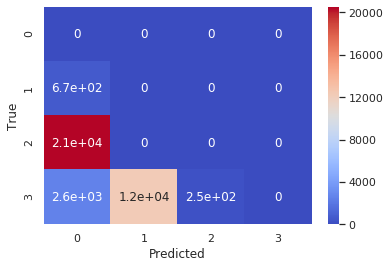

time: 337 ms


In [0]:
sns.heatmap(cmpp3,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

## Change to correct labels

In [0]:
labelspp3 = kmeansc1pp3.labels_
labelspp3[labelspp3 == 0] = 4
labelspp3[labelspp3 == 1] = 5
labelspp3[labelspp3 == 2] = 6

time: 1.92 ms


In [0]:
labelspp3[labelspp3 == 4] = 2
labelspp3[labelspp3 == 5] = 3
labelspp3[labelspp3 == 6] = 1

time: 3.59 ms


## Check heatmap

In [0]:
cmpp3 = confusion_matrix(target_system, labelspp3)

time: 36.1 ms


Text(30.5, 0.5, 'True')

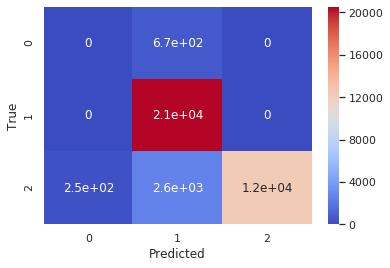

time: 272 ms


In [0]:
sns.heatmap(cmpp3,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

In [0]:
reportpp3 = classification_report(target_system, labelspp3,output_dict = True)

time: 37.2 ms


In [0]:
reportpp3

{'1': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 671},
 '2': {'f1-score': 0.9258908434821831,
  'precision': 0.8620081468105657,
  'recall': 1.0,
  'support': 20527},
 '3': {'f1-score': 0.895594183885427,
  'precision': 1.0,
  'recall': 0.8109285290041576,
  'support': 15153},
 'accuracy': 0.9027261973535804,
 'macro avg': {'f1-score': 0.6071616757892033,
  'precision': 0.6206693822701886,
  'recall': 0.6036428430013858,
  'support': 36351},
 'weighted avg': {'f1-score': 0.8961706696535073,
  'precision': 0.9036186412913119,
  'recall': 0.9027261973535804,
  'support': 36351}}

time: 6.12 ms


## Calculating the elbow method (optimal number of clusters)

In [0]:
wcss =[]
for i in range(1,30):
  kmeanModel = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
  kmeanModel.fit(dfsc1)
  wcss.append(kmeanModel.inertia_)

time: 32.3 s


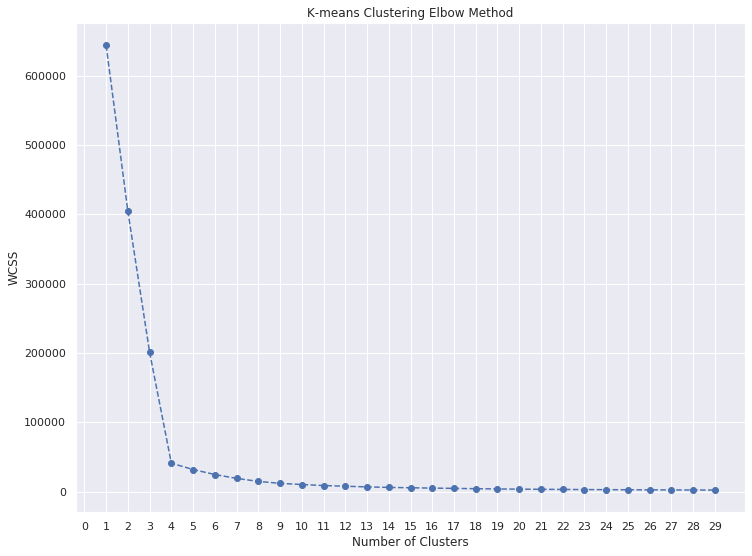

time: 486 ms


In [0]:
plt.figure(figsize=(12,9))
plt.plot(range(1,30),wcss,marker='o',linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(np.arange(0, 30, 1))
plt.title('K-means Clustering Elbow Method')
plt.show()

## Results analysis

In [0]:
print("Confusion matrix\n",metrics.confusion_matrix(y_true=target_system.System,y_pred=labelspp3)) 
print("Classification report\n",metrics.classification_report(y_true=target_system.System,y_pred=labelspp3)) 

Confusion matrix
 [[    0   671     0]
 [    0 20527     0]
 [  250  2615 12288]]
Classification report
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       671
           2       0.86      1.00      0.93     20527
           3       1.00      0.81      0.90     15153

    accuracy                           0.90     36351
   macro avg       0.62      0.60      0.61     36351
weighted avg       0.90      0.90      0.90     36351

time: 71.9 ms


In [0]:
print('\033[1m'+"Kmeans++:"+'\033[0m')
print('\033[1m'+"System 1"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3["1"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3["1"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3["1"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3["1"]["support"]))
print('\033[1m'+"System 2"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3["2"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3["2"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3["2"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3["2"]["support"]))
print('\033[1m'+"System 3"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3["3"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3["3"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3["3"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3["3"]["support"]))

Kmeans++:
System 1
Precision = 0.000
Recall = 0.000
F1-score = 0.000
Support = 671.000
System 2
Precision = 0.862
Recall = 1.000
F1-score = 0.926
Support = 20527.000
System 3
Precision = 1.000
Recall = 0.811
F1-score = 0.896
Support = 15153.000
time: 17 ms


In [0]:
print('\033[1m'+'Clustering metrics - supervised'+'\033[0m')
print('Adjusted Rand score: ', metrics.adjusted_rand_score(target_system.System, labelspp3))
print('Mutual info score: ', metrics.adjusted_mutual_info_score(target_system.System, labelspp3))
print('Homogeneity score: ', metrics.homogeneity_score(target_system.System, labelspp3))
print('Completeness score: ', metrics.completeness_score(target_system.System, labelspp3))
print('V-measure: ', metrics.v_measure_score(target_system.System, labelspp3))
print('Fowlkes-Mallows score: ', metrics.fowlkes_mallows_score(target_system.System, labelspp3))

Clustering metrics - supervised
Adjusted Rand score:  0.6823361077431518
Mutual info score:  0.6288415438002335
Homogeneity score:  0.5945082951466247
Completeness score:  0.6674481883802669
V-measure:  0.6288703132831919
Fowlkes-Mallows score:  0.8475658942266868
time: 62.6 ms


In [0]:
print('\033[1m'+'Clustering metrics - unsupervised'+'\033[0m')
print('Silhouette: ',metrics.silhouette_score(dfsc1, labelspp3, metric='euclidean'))
print('Davies-Bouldin Index: ',metrics.davies_bouldin_score(dfsc1, labelspp3))
print('Calinski-Harabasz Index: ',metrics.calinski_harabaz_score(dfsc1, labelspp3))

Clustering metrics - unsupervised
Silhouette:  0.7084899313103125
Davies-Bouldin Index:  0.35351468150384296
Calinski-Harabasz Index:  40095.43389737366
time: 18.9 s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)


## Hyperparameter analysis: n_init

### 3 scenarios: 100, 300 and 500

### 01 - n_init = 100

In [0]:
kmeansc1pp3hyp1_01 = KMeans(n_clusters=3, random_state=42, n_init=100).fit(dfsc1)

time: 1.47 s


In [0]:
kmeansc1pp3hyp1_01.labels_

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

time: 5.26 ms


In [0]:
sc1pp3labelshyp1_01 = pd.Series(kmeansc1pp3hyp1_01.labels_)

time: 1.52 ms


In [0]:
sc1pp3labelshyp1_01.value_counts()

0    23813
1    12288
2      250
dtype: int64

time: 17.5 ms


In [0]:
cmpp3hyp1_01 = confusion_matrix(target_system.System, sc1pp3labelshyp1_01)

time: 71.1 ms


In [0]:
cmpp3hyp1_01

array([[    0,     0,     0,     0],
       [  671,     0,     0,     0],
       [20527,     0,     0,     0],
       [ 2615, 12288,   250,     0]])

time: 5.28 ms


## Check correct labels

Text(30.5, 0.5, 'True')

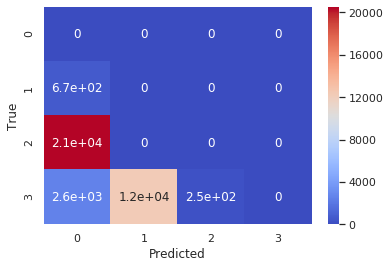

time: 314 ms


In [0]:
sns.heatmap(cmpp3hyp1_01,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

## Change to correct labels

In [0]:
sc1pp3labelshyp1_01
sc1pp3labelshyp1_01[sc1pp3labelshyp1_01 == 0] = 4
sc1pp3labelshyp1_01[sc1pp3labelshyp1_01 == 1] = 5
sc1pp3labelshyp1_01[sc1pp3labelshyp1_01 == 2] = 6

time: 14.5 ms


In [0]:
sc1pp3labelshyp1_01[sc1pp3labelshyp1_01 == 4] = 2
sc1pp3labelshyp1_01[sc1pp3labelshyp1_01 == 5] = 3
sc1pp3labelshyp1_01[sc1pp3labelshyp1_01 == 6] = 1

time: 15.5 ms


## Check heatmap

In [0]:
cmpp3hyp1_01 = confusion_matrix(target_system.System, sc1pp3labelshyp1_01)

time: 35.9 ms


In [0]:
cmpp3hyp1_01

array([[    0,   671,     0],
       [    0, 20527,     0],
       [  250,  2615, 12288]])

time: 3.58 ms


Text(30.5, 0.5, 'True')

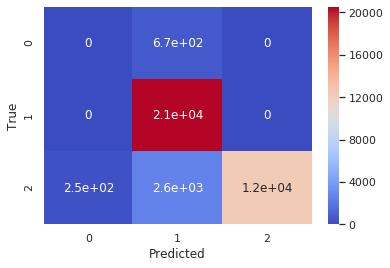

time: 271 ms


In [0]:
sns.heatmap(cmpp3hyp1_01,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

In [0]:
reportpp3hyp1_01 = classification_report(target_system, sc1pp3labelshyp1_01,output_dict = True)

time: 39.9 ms


In [0]:
reportpp3hyp1_01

{'1': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 671},
 '2': {'f1-score': 0.9258908434821831,
  'precision': 0.8620081468105657,
  'recall': 1.0,
  'support': 20527},
 '3': {'f1-score': 0.895594183885427,
  'precision': 1.0,
  'recall': 0.8109285290041576,
  'support': 15153},
 'accuracy': 0.9027261973535804,
 'macro avg': {'f1-score': 0.6071616757892033,
  'precision': 0.6206693822701886,
  'recall': 0.6036428430013858,
  'support': 36351},
 'weighted avg': {'f1-score': 0.8961706696535073,
  'precision': 0.9036186412913119,
  'recall': 0.9027261973535804,
  'support': 36351}}

time: 3.75 ms


In [0]:
print("Confusion matrix\n",metrics.confusion_matrix(y_true=target_system.System,y_pred=sc1pp3labelshyp1_01)) 
print("Classification report\n",metrics.classification_report(y_true=target_system.System,y_pred=sc1pp3labelshyp1_01))

Confusion matrix
 [[    0   671     0]
 [    0 20527     0]
 [  250  2615 12288]]
Classification report
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       671
           2       0.86      1.00      0.93     20527
           3       1.00      0.81      0.90     15153

    accuracy                           0.90     36351
   macro avg       0.62      0.60      0.61     36351
weighted avg       0.90      0.90      0.90     36351

time: 80.5 ms


In [0]:
print('\033[1m'+"Kmeans++:"+'\033[0m')
print('\033[1m'+"System 1"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp1_01["1"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp1_01["1"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp1_01["1"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp1_01["1"]["support"]))
print('\033[1m'+"System 2"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp1_01["2"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp1_01["2"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp1_01["2"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp1_01["2"]["support"]))
print('\033[1m'+"System 3"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp1_01["3"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp1_01["3"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp1_01["3"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp1_01["3"]["support"]))

Kmeans++:
System 1
Precision = 0.000
Recall = 0.000
F1-score = 0.000
Support = 671.000
System 2
Precision = 0.862
Recall = 1.000
F1-score = 0.926
Support = 20527.000
System 3
Precision = 1.000
Recall = 0.811
F1-score = 0.896
Support = 15153.000
time: 18.4 ms


In [0]:
print('\033[1m'+'Clustering metrics - supervised'+'\033[0m')
print('Adjusted Rand score: ', metrics.adjusted_rand_score(target_system.System, sc1pp3labelshyp1_01))
print('Mutual info score: ', metrics.adjusted_mutual_info_score(target_system.System, sc1pp3labelshyp1_01))
print('Homogeneity score: ', metrics.homogeneity_score(target_system.System, sc1pp3labelshyp1_01))
print('Completeness score: ', metrics.completeness_score(target_system.System, sc1pp3labelshyp1_01))
print('V-measure: ', metrics.v_measure_score(target_system.System, sc1pp3labelshyp1_01))
print('Fowlkes-Mallows score: ', metrics.fowlkes_mallows_score(target_system.System, sc1pp3labelshyp1_01))

Clustering metrics - supervised
Adjusted Rand score:  0.6823361077431518
Mutual info score:  0.6288415438002335
Homogeneity score:  0.5945082951466247
Completeness score:  0.6674481883802669
V-measure:  0.6288703132831919
Fowlkes-Mallows score:  0.8475658942266868
time: 60.4 ms


In [0]:
print('\033[1m'+'Clustering metrics - unsupervised'+'\033[0m')
print('Silhouette: ',metrics.silhouette_score(dfsc1, sc1pp3labelshyp1_01, metric='euclidean'))
print('Davies-Bouldin Index: ',metrics.davies_bouldin_score(dfsc1, sc1pp3labelshyp1_01))
print('Calinski-Harabasz Index: ',metrics.calinski_harabaz_score(dfsc1, sc1pp3labelshyp1_01))

Clustering metrics - unsupervised
Silhouette:  0.7084899313103125
Davies-Bouldin Index:  0.35351468150384296
Calinski-Harabasz Index:  40095.43389737366
time: 18.8 s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)


### 02 - n_init = 300

In [0]:
kmeansc1pp3hyp1_02 = KMeans(n_clusters=3, random_state=42, n_init=300).fit(dfsc1)

time: 4.33 s


In [0]:
kmeansc1pp3hyp1_02.labels_

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

time: 5.55 ms


In [0]:
sc1pp3labelshyp1_02 = pd.Series(kmeansc1pp3hyp1_02.labels_)

time: 1.15 ms


In [0]:
sc1pp3labelshyp1_02.value_counts()

0    23813
1    12288
2      250
dtype: int64

time: 13.4 ms


In [0]:
cmpp3hyp1_02 = confusion_matrix(target_system.System, sc1pp3labelshyp1_02)

time: 53 ms


In [0]:
cmpp3hyp1_02

array([[    0,     0,     0,     0],
       [  671,     0,     0,     0],
       [20527,     0,     0,     0],
       [ 2615, 12288,   250,     0]])

time: 4.52 ms


## Check correct labels

Text(30.5, 0.5, 'True')

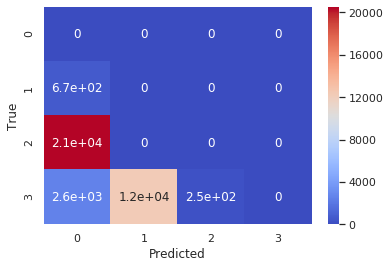

time: 307 ms


In [0]:
sns.heatmap(cmpp3hyp1_02,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

## Change to correct labels

In [0]:
sc1pp3labelshyp1_02
sc1pp3labelshyp1_02[sc1pp3labelshyp1_02 == 0] = 4
sc1pp3labelshyp1_02[sc1pp3labelshyp1_02 == 1] = 5
sc1pp3labelshyp1_02[sc1pp3labelshyp1_02 == 2] = 6

time: 16.9 ms


In [0]:
sc1pp3labelshyp1_02[sc1pp3labelshyp1_02 == 4] = 2
sc1pp3labelshyp1_02[sc1pp3labelshyp1_02 == 5] = 3
sc1pp3labelshyp1_02[sc1pp3labelshyp1_02 == 6] = 1

time: 13.9 ms


## Check heatmap

In [0]:
cmpp3hyp1_02 = confusion_matrix(target_system.System, sc1pp3labelshyp1_02)

time: 36 ms


In [0]:
cmpp3hyp1_02

array([[    0,   671,     0],
       [    0, 20527,     0],
       [  250,  2615, 12288]])

time: 5.31 ms


Text(30.5, 0.5, 'True')

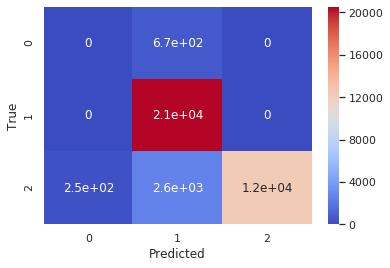

time: 285 ms


In [0]:
sns.heatmap(cmpp3hyp1_02,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

In [0]:
reportpp3hyp1_02 = classification_report(target_system, sc1pp3labelshyp1_02,output_dict = True)

time: 36.6 ms


In [0]:
reportpp3hyp1_02

{'1': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 671},
 '2': {'f1-score': 0.9258908434821831,
  'precision': 0.8620081468105657,
  'recall': 1.0,
  'support': 20527},
 '3': {'f1-score': 0.895594183885427,
  'precision': 1.0,
  'recall': 0.8109285290041576,
  'support': 15153},
 'accuracy': 0.9027261973535804,
 'macro avg': {'f1-score': 0.6071616757892033,
  'precision': 0.6206693822701886,
  'recall': 0.6036428430013858,
  'support': 36351},
 'weighted avg': {'f1-score': 0.8961706696535073,
  'precision': 0.9036186412913119,
  'recall': 0.9027261973535804,
  'support': 36351}}

time: 5.31 ms


In [0]:
print("Confusion matrix\n",metrics.confusion_matrix(y_true=target_system.System,y_pred=sc1pp3labelshyp1_02)) 
print("Classification report\n",metrics.classification_report(y_true=target_system.System,y_pred=sc1pp3labelshyp1_02))

Confusion matrix
 [[    0   671     0]
 [    0 20527     0]
 [  250  2615 12288]]
Classification report
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       671
           2       0.86      1.00      0.93     20527
           3       1.00      0.81      0.90     15153

    accuracy                           0.90     36351
   macro avg       0.62      0.60      0.61     36351
weighted avg       0.90      0.90      0.90     36351

time: 72.3 ms


In [0]:
print('\033[1m'+"Kmeans++:"+'\033[0m')
print('\033[1m'+"System 1"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp1_02["1"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp1_02["1"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp1_02["1"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp1_02["1"]["support"]))
print('\033[1m'+"System 2"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp1_02["2"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp1_02["2"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp1_02["2"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp1_02["2"]["support"]))
print('\033[1m'+"System 3"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp1_02["3"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp1_02["3"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp1_02["3"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp1_02["3"]["support"]))

Kmeans++:
System 1
Precision = 0.000
Recall = 0.000
F1-score = 0.000
Support = 671.000
System 2
Precision = 0.862
Recall = 1.000
F1-score = 0.926
Support = 20527.000
System 3
Precision = 1.000
Recall = 0.811
F1-score = 0.896
Support = 15153.000
time: 17.1 ms


In [0]:
print('\033[1m'+'Clustering metrics - supervised'+'\033[0m')
print('Adjusted Rand score: ', metrics.adjusted_rand_score(target_system.System, sc1pp3labelshyp1_02))
print('Mutual info score: ', metrics.adjusted_mutual_info_score(target_system.System, sc1pp3labelshyp1_02))
print('Homogeneity score: ', metrics.homogeneity_score(target_system.System, sc1pp3labelshyp1_02))
print('Completeness score: ', metrics.completeness_score(target_system.System, sc1pp3labelshyp1_02))
print('V-measure: ', metrics.v_measure_score(target_system.System, sc1pp3labelshyp1_02))
print('Fowlkes-Mallows score: ', metrics.fowlkes_mallows_score(target_system.System, sc1pp3labelshyp1_02))

Clustering metrics - supervised
Adjusted Rand score:  0.6823361077431518
Mutual info score:  0.6288415438002335
Homogeneity score:  0.5945082951466247
Completeness score:  0.6674481883802669
V-measure:  0.6288703132831919
Fowlkes-Mallows score:  0.8475658942266868
time: 74.4 ms


In [0]:
print('\033[1m'+'Clustering metrics - unsupervised'+'\033[0m')
print('Silhouette: ',metrics.silhouette_score(dfsc1, sc1pp3labelshyp1_02, metric='euclidean'))
print('Davies-Bouldin Index: ',metrics.davies_bouldin_score(dfsc1, sc1pp3labelshyp1_02))
print('Calinski-Harabasz Index: ',metrics.calinski_harabaz_score(dfsc1, sc1pp3labelshyp1_02))

Clustering metrics - unsupervised
Silhouette:  0.7084899313103125
Davies-Bouldin Index:  0.35351468150384296
Calinski-Harabasz Index:  40095.43389737366
time: 18.8 s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)


### 03 - n_init = 500

In [0]:
kmeansc1pp3hyp1_03 = KMeans(n_clusters=3, random_state=42, n_init=500).fit(dfsc1)

time: 7.12 s


In [0]:
kmeansc1pp3hyp1_03.labels_

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

time: 7.14 ms


In [0]:
sc1pp3labelshyp1_03 = pd.Series(kmeansc1pp3hyp1_03.labels_)

time: 1.17 ms


In [0]:
sc1pp3labelshyp1_03.value_counts()

0    23813
1    12288
2      250
dtype: int64

time: 17.6 ms


In [0]:
cmpp3hyp1_03 = confusion_matrix(target_system.System, sc1pp3labelshyp1_03)

time: 44.3 ms


In [0]:
cmpp3hyp1_03

array([[    0,     0,     0,     0],
       [  671,     0,     0,     0],
       [20527,     0,     0,     0],
       [ 2615, 12288,   250,     0]])

time: 5.4 ms


## Check correct labels

Text(30.5, 0.5, 'True')

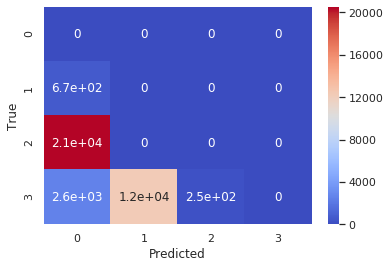

time: 285 ms


In [0]:
sns.heatmap(cmpp3hyp1_03,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

## Change to correct labels

In [0]:
sc1pp3labelshyp1_03
sc1pp3labelshyp1_03[sc1pp3labelshyp1_03 == 0] = 4
sc1pp3labelshyp1_03[sc1pp3labelshyp1_03 == 1] = 5
sc1pp3labelshyp1_03[sc1pp3labelshyp1_03 == 2] = 6

time: 18.2 ms


In [0]:
sc1pp3labelshyp1_03[sc1pp3labelshyp1_03 == 4] = 2
sc1pp3labelshyp1_03[sc1pp3labelshyp1_03 == 5] = 3
sc1pp3labelshyp1_03[sc1pp3labelshyp1_03 == 6] = 1

time: 15.2 ms


## Check heatmap

In [0]:
cmpp3hyp1_03 = confusion_matrix(target_system.System, sc1pp3labelshyp1_03)

time: 36.4 ms


In [0]:
cmpp3hyp1_03

array([[    0,   671,     0],
       [    0, 20527,     0],
       [  250,  2615, 12288]])

time: 4.38 ms


Text(30.5, 0.5, 'True')

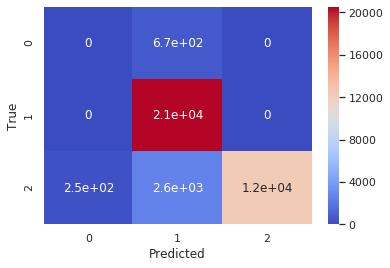

time: 281 ms


In [0]:
sns.heatmap(cmpp3hyp1_03,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

In [0]:
reportpp3hyp1_03 = classification_report(target_system, sc1pp3labelshyp1_03,output_dict = True)

time: 40.8 ms


In [0]:
reportpp3hyp1_03

{'1': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 671},
 '2': {'f1-score': 0.9258908434821831,
  'precision': 0.8620081468105657,
  'recall': 1.0,
  'support': 20527},
 '3': {'f1-score': 0.895594183885427,
  'precision': 1.0,
  'recall': 0.8109285290041576,
  'support': 15153},
 'accuracy': 0.9027261973535804,
 'macro avg': {'f1-score': 0.6071616757892033,
  'precision': 0.6206693822701886,
  'recall': 0.6036428430013858,
  'support': 36351},
 'weighted avg': {'f1-score': 0.8961706696535073,
  'precision': 0.9036186412913119,
  'recall': 0.9027261973535804,
  'support': 36351}}

time: 7.84 ms


In [0]:
print("Confusion matrix\n",metrics.confusion_matrix(y_true=target_system.System,y_pred=sc1pp3labelshyp1_03)) 
print("Classification report\n",metrics.classification_report(y_true=target_system.System,y_pred=sc1pp3labelshyp1_03)) 

Confusion matrix
 [[    0   671     0]
 [    0 20527     0]
 [  250  2615 12288]]
Classification report
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       671
           2       0.86      1.00      0.93     20527
           3       1.00      0.81      0.90     15153

    accuracy                           0.90     36351
   macro avg       0.62      0.60      0.61     36351
weighted avg       0.90      0.90      0.90     36351

time: 72 ms


In [0]:
print('\033[1m'+"Kmeans++:"+'\033[0m')
print('\033[1m'+"System 1"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp1_03["1"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp1_03["1"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp1_03["1"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp1_03["1"]["support"]))
print('\033[1m'+"System 2"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp1_03["2"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp1_03["2"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp1_03["2"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp1_03["2"]["support"]))
print('\033[1m'+"System 3"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp1_03["3"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp1_03["3"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp1_03["3"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp1_03["3"]["support"]))

Kmeans++:
System 1
Precision = 0.000
Recall = 0.000
F1-score = 0.000
Support = 671.000
System 2
Precision = 0.862
Recall = 1.000
F1-score = 0.926
Support = 20527.000
System 3
Precision = 1.000
Recall = 0.811
F1-score = 0.896
Support = 15153.000
time: 19.4 ms


In [0]:
print('\033[1m'+'Clustering metrics - supervised'+'\033[0m')
print('Adjusted Rand score: ', metrics.adjusted_rand_score(target_system.System, sc1pp3labelshyp1_03))
print('Mutual info score: ', metrics.adjusted_mutual_info_score(target_system.System, sc1pp3labelshyp1_03))
print('Homogeneity score: ', metrics.homogeneity_score(target_system.System, sc1pp3labelshyp1_03))
print('Completeness score: ', metrics.completeness_score(target_system.System, sc1pp3labelshyp1_03))
print('V-measure: ', metrics.v_measure_score(target_system.System, sc1pp3labelshyp1_03))
print('Fowlkes-Mallows score: ', metrics.fowlkes_mallows_score(target_system.System, sc1pp3labelshyp1_03))

Clustering metrics - supervised
Adjusted Rand score:  0.6823361077431518
Mutual info score:  0.6288415438002335
Homogeneity score:  0.5945082951466247
Completeness score:  0.6674481883802669
V-measure:  0.6288703132831919
Fowlkes-Mallows score:  0.8475658942266868
time: 65.4 ms


In [0]:
print('\033[1m'+'Clustering metrics - unsupervised'+'\033[0m')
print('Silhouette: ',metrics.silhouette_score(dfsc1, sc1pp3labelshyp1_03, metric='euclidean'))
print('Davies-Bouldin Index: ',metrics.davies_bouldin_score(dfsc1, sc1pp3labelshyp1_03))
print('Calinski-Harabasz Index: ',metrics.calinski_harabaz_score(dfsc1, sc1pp3labelshyp1_03))

Clustering metrics - unsupervised
Silhouette:  0.7084899313103125
Davies-Bouldin Index:  0.35351468150384296
Calinski-Harabasz Index:  40095.43389737366
time: 19.1 s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)


## Hyperparameter analysis: max_iter

### 3 scenarios: 100, 300 and 500

### 01 - max_iter = 100

In [0]:
kmeansc1pp3hyp2_01 = KMeans(n_clusters=3, random_state=42, max_iter=100).fit(dfsc1)

time: 159 ms


In [0]:
kmeansc1pp3hyp2_01.labels_

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

time: 3.95 ms


In [0]:
sc1pp3labelshyp2_01 = pd.Series(kmeansc1pp3hyp2_01.labels_)

time: 1.69 ms


In [0]:
sc1pp3labelshyp2_01.value_counts()

0    23813
1    12288
2      250
dtype: int64

time: 9.44 ms


In [0]:
cmpp3hyp2_01 = confusion_matrix(target_system.System, sc1pp3labelshyp2_01)

time: 61.7 ms


In [0]:
cmpp3hyp2_01

array([[    0,     0,     0,     0],
       [  671,     0,     0,     0],
       [20527,     0,     0,     0],
       [ 2615, 12288,   250,     0]])

time: 4.91 ms


## Check correct labels

Text(30.5, 0.5, 'True')

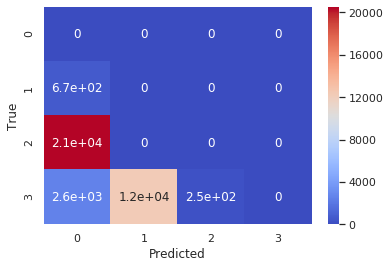

time: 375 ms


In [0]:
sns.heatmap(cmpp3hyp2_01,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

## Change to correct labels

In [0]:
sc1pp3labelshyp2_01
sc1pp3labelshyp2_01[sc1pp3labelshyp2_01 == 0] = 4
sc1pp3labelshyp2_01[sc1pp3labelshyp2_01 == 1] = 5
sc1pp3labelshyp2_01[sc1pp3labelshyp2_01 == 2] = 6

time: 15.6 ms


In [0]:
sc1pp3labelshyp2_01[sc1pp3labelshyp2_01 == 4] = 2
sc1pp3labelshyp2_01[sc1pp3labelshyp2_01 == 5] = 3
sc1pp3labelshyp2_01[sc1pp3labelshyp2_01 == 6] = 1

time: 13.5 ms


## Check heatmap

In [0]:
cmpp3hyp2_01 = confusion_matrix(target_system.System, sc1pp3labelshyp2_01)

time: 38.4 ms


In [0]:
cmpp3hyp2_01

array([[    0,   671,     0],
       [    0, 20527,     0],
       [  250,  2615, 12288]])

time: 3.51 ms


Text(30.5, 0.5, 'True')

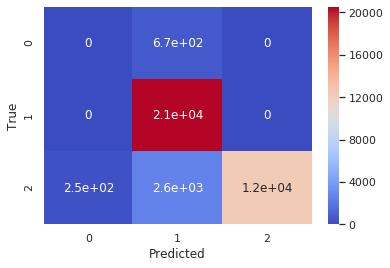

time: 264 ms


In [0]:
sns.heatmap(cmpp3hyp2_01,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

In [0]:
reportpp3hyp2_01 = classification_report(target_system, sc1pp3labelshyp2_01,output_dict = True)

time: 39.7 ms


In [0]:
reportpp3hyp2_01

{'1': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 671},
 '2': {'f1-score': 0.9258908434821831,
  'precision': 0.8620081468105657,
  'recall': 1.0,
  'support': 20527},
 '3': {'f1-score': 0.895594183885427,
  'precision': 1.0,
  'recall': 0.8109285290041576,
  'support': 15153},
 'accuracy': 0.9027261973535804,
 'macro avg': {'f1-score': 0.6071616757892033,
  'precision': 0.6206693822701886,
  'recall': 0.6036428430013858,
  'support': 36351},
 'weighted avg': {'f1-score': 0.8961706696535073,
  'precision': 0.9036186412913119,
  'recall': 0.9027261973535804,
  'support': 36351}}

time: 4.54 ms


In [0]:
print("Confusion matrix\n",metrics.confusion_matrix(y_true=target_system.System,y_pred=sc1pp3labelshyp2_01)) 
print("Classification report\n",metrics.classification_report(y_true=target_system.System,y_pred=sc1pp3labelshyp2_01))

Confusion matrix
 [[    0   671     0]
 [    0 20527     0]
 [  250  2615 12288]]
Classification report
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       671
           2       0.86      1.00      0.93     20527
           3       1.00      0.81      0.90     15153

    accuracy                           0.90     36351
   macro avg       0.62      0.60      0.61     36351
weighted avg       0.90      0.90      0.90     36351

time: 73.6 ms


In [0]:
print('\033[1m'+"Kmeans++:"+'\033[0m')
print('\033[1m'+"System 1"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp2_01["1"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp2_01["1"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp2_01["1"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp2_01["1"]["support"]))
print('\033[1m'+"System 2"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp2_01["2"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp2_01["2"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp2_01["2"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp2_01["2"]["support"]))
print('\033[1m'+"System 3"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp2_01["3"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp2_01["3"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp2_01["3"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp2_01["3"]["support"]))

Kmeans++:
System 1
Precision = 0.000
Recall = 0.000
F1-score = 0.000
Support = 671.000
System 2
Precision = 0.862
Recall = 1.000
F1-score = 0.926
Support = 20527.000
System 3
Precision = 1.000
Recall = 0.811
F1-score = 0.896
Support = 15153.000
time: 19.5 ms


In [0]:
print('\033[1m'+'Clustering metrics - supervised'+'\033[0m')
print('Adjusted Rand score: ', metrics.adjusted_rand_score(target_system.System, sc1pp3labelshyp2_01))
print('Mutual info score: ', metrics.adjusted_mutual_info_score(target_system.System, sc1pp3labelshyp2_01))
print('Homogeneity score: ', metrics.homogeneity_score(target_system.System, sc1pp3labelshyp2_01))
print('Completeness score: ', metrics.completeness_score(target_system.System, sc1pp3labelshyp2_01))
print('V-measure: ', metrics.v_measure_score(target_system.System, sc1pp3labelshyp2_01))
print('Fowlkes-Mallows score: ', metrics.fowlkes_mallows_score(target_system.System, sc1pp3labelshyp2_01))

Clustering metrics - supervised
Adjusted Rand score:  0.6823361077431518
Mutual info score:  0.6288415438002335
Homogeneity score:  0.5945082951466247
Completeness score:  0.6674481883802669
V-measure:  0.6288703132831919
Fowlkes-Mallows score:  0.8475658942266868
time: 59.5 ms


In [0]:
print('\033[1m'+'Clustering metrics - unsupervised'+'\033[0m')
print('Silhouette: ',metrics.silhouette_score(dfsc1, sc1pp3labelshyp2_01, metric='euclidean'))
print('Davies-Bouldin Index: ',metrics.davies_bouldin_score(dfsc1, sc1pp3labelshyp2_01))
print('Calinski-Harabasz Index: ',metrics.calinski_harabaz_score(dfsc1, sc1pp3labelshyp2_01))

Clustering metrics - unsupervised
Silhouette:  0.7084899313103125
Davies-Bouldin Index:  0.35351468150384296
Calinski-Harabasz Index:  40095.43389737366
time: 18.9 s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)


### 02 - max_iter = 500

In [0]:
kmeansc1pp3hyp2_02 = KMeans(n_clusters=3, random_state=42, max_iter=500).fit(dfsc1)

time: 167 ms


In [0]:
kmeansc1pp3hyp2_02.labels_

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

time: 11.5 ms


In [0]:
sc1pp3labelshyp2_02 = pd.Series(kmeansc1pp3hyp2_02.labels_)

time: 1.2 ms


In [0]:
sc1pp3labelshyp2_02.value_counts()

0    23813
1    12288
2      250
dtype: int64

time: 16.1 ms


In [0]:
cmpp3hyp2_02 = confusion_matrix(target_system.System, sc1pp3labelshyp2_02)

time: 48.7 ms


In [0]:
cmpp3hyp2_02

array([[    0,     0,     0,     0],
       [  671,     0,     0,     0],
       [20527,     0,     0,     0],
       [ 2615, 12288,   250,     0]])

time: 7.36 ms


## Check correct labels

Text(30.5, 0.5, 'True')

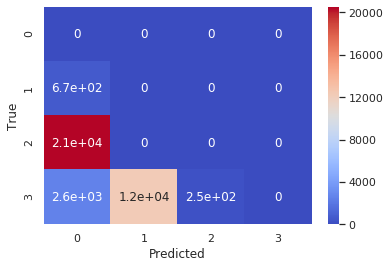

time: 308 ms


In [0]:
sns.heatmap(cmpp3hyp2_02,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

## Change to correct labels

In [0]:
sc1pp3labelshyp2_02
sc1pp3labelshyp2_02[sc1pp3labelshyp2_02 == 0] = 4
sc1pp3labelshyp2_02[sc1pp3labelshyp2_02 == 1] = 5
sc1pp3labelshyp2_02[sc1pp3labelshyp2_02 == 2] = 6

time: 16.5 ms


In [0]:
sc1pp3labelshyp2_02[sc1pp3labelshyp2_02 == 4] = 2
sc1pp3labelshyp2_02[sc1pp3labelshyp2_02 == 5] = 3
sc1pp3labelshyp2_02[sc1pp3labelshyp2_02 == 6] = 1

time: 21 ms


## Check heatmap

In [0]:
cmpp3hyp2_02 = confusion_matrix(target_system.System, sc1pp3labelshyp2_02)

time: 37.2 ms


In [0]:
cmpp3hyp2_02

array([[    0,   671,     0],
       [    0, 20527,     0],
       [  250,  2615, 12288]])

time: 6.87 ms


Text(30.5, 0.5, 'True')

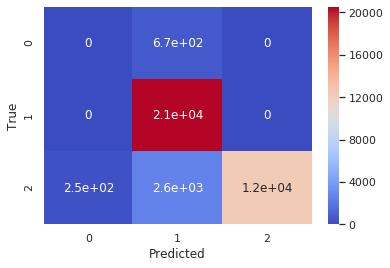

time: 256 ms


In [0]:
sns.heatmap(cmpp3hyp2_02,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

In [0]:
reportpp3hyp2_02 = classification_report(target_system, sc1pp3labelshyp2_02,output_dict = True)

time: 36.1 ms


In [0]:
reportpp3hyp2_02

{'1': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 671},
 '2': {'f1-score': 0.9258908434821831,
  'precision': 0.8620081468105657,
  'recall': 1.0,
  'support': 20527},
 '3': {'f1-score': 0.895594183885427,
  'precision': 1.0,
  'recall': 0.8109285290041576,
  'support': 15153},
 'accuracy': 0.9027261973535804,
 'macro avg': {'f1-score': 0.6071616757892033,
  'precision': 0.6206693822701886,
  'recall': 0.6036428430013858,
  'support': 36351},
 'weighted avg': {'f1-score': 0.8961706696535073,
  'precision': 0.9036186412913119,
  'recall': 0.9027261973535804,
  'support': 36351}}

time: 6.89 ms


In [0]:
print("Confusion matrix\n",metrics.confusion_matrix(y_true=target_system.System,y_pred=sc1pp3labelshyp2_02)) 
print("Classification report\n",metrics.classification_report(y_true=target_system.System,y_pred=sc1pp3labelshyp2_02)) 

Confusion matrix
 [[    0   671     0]
 [    0 20527     0]
 [  250  2615 12288]]
Classification report
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       671
           2       0.86      1.00      0.93     20527
           3       1.00      0.81      0.90     15153

    accuracy                           0.90     36351
   macro avg       0.62      0.60      0.61     36351
weighted avg       0.90      0.90      0.90     36351

time: 78.8 ms


In [0]:
print('\033[1m'+"Kmeans++:"+'\033[0m')
print('\033[1m'+"System 1"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp2_02["1"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp2_02["1"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp2_02["1"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp2_02["1"]["support"]))
print('\033[1m'+"System 2"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp2_02["2"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp2_02["2"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp2_02["2"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp2_02["2"]["support"]))
print('\033[1m'+"System 3"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp2_02["3"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp2_02["3"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp2_02["3"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp2_02["3"]["support"]))

Kmeans++:
System 1
Precision = 0.000
Recall = 0.000
F1-score = 0.000
Support = 671.000
System 2
Precision = 0.862
Recall = 1.000
F1-score = 0.926
Support = 20527.000
System 3
Precision = 1.000
Recall = 0.811
F1-score = 0.896
Support = 15153.000
time: 18.4 ms


In [0]:
print('\033[1m'+'Clustering metrics - supervised'+'\033[0m')
print('Adjusted Rand score: ', metrics.adjusted_rand_score(target_system.System, sc1pp3labelshyp2_02))
print('Mutual info score: ', metrics.adjusted_mutual_info_score(target_system.System, sc1pp3labelshyp2_02))
print('Homogeneity score: ', metrics.homogeneity_score(target_system.System, sc1pp3labelshyp2_02))
print('Completeness score: ', metrics.completeness_score(target_system.System, sc1pp3labelshyp2_02))
print('V-measure: ', metrics.v_measure_score(target_system.System, sc1pp3labelshyp2_02))
print('Fowlkes-Mallows score: ', metrics.fowlkes_mallows_score(target_system.System, sc1pp3labelshyp2_02))

Clustering metrics - supervised
Adjusted Rand score:  0.6823361077431518
Mutual info score:  0.6288415438002335
Homogeneity score:  0.5945082951466247
Completeness score:  0.6674481883802669
V-measure:  0.6288703132831919
Fowlkes-Mallows score:  0.8475658942266868
time: 67.4 ms


In [0]:
print('\033[1m'+'Clustering metrics - unsupervised'+'\033[0m')
print('Silhouette: ',metrics.silhouette_score(dfsc1, sc1pp3labelshyp2_02, metric='euclidean'))
print('Davies-Bouldin Index: ',metrics.davies_bouldin_score(dfsc1, sc1pp3labelshyp2_02))
print('Calinski-Harabasz Index: ',metrics.calinski_harabaz_score(dfsc1, sc1pp3labelshyp2_02))

Clustering metrics - unsupervised
Silhouette:  0.7084899313103125
Davies-Bouldin Index:  0.35351468150384296
Calinski-Harabasz Index:  40095.43389737366
time: 18.8 s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)


### 03 - max_iter = 1000

In [0]:
kmeansc1pp3hyp2_03 = KMeans(n_clusters=3, random_state=42, max_iter=1000).fit(dfsc1)

time: 159 ms


In [0]:
kmeansc1pp3hyp2_03.labels_

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

time: 7.26 ms


In [0]:
sc1pp3labelshyp2_03 = pd.Series(kmeansc1pp3hyp2_03.labels_)

time: 1.33 ms


In [0]:
sc1pp3labelshyp2_03.value_counts()

0    23813
1    12288
2      250
dtype: int64

time: 15.5 ms


In [0]:
cmpp3hyp2_03 = confusion_matrix(target_system.System, sc1pp3labelshyp2_03)

time: 56 ms


In [0]:
cmpp3hyp2_03

array([[    0,     0,     0,     0],
       [  671,     0,     0,     0],
       [20527,     0,     0,     0],
       [ 2615, 12288,   250,     0]])

time: 6.25 ms


## Check correct labels

Text(30.5, 0.5, 'True')

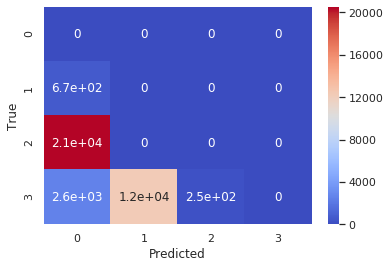

time: 312 ms


In [0]:
sns.heatmap(cmpp3hyp2_03,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

## Change to correct labels

In [0]:
sc1pp3labelshyp2_03
sc1pp3labelshyp2_03[sc1pp3labelshyp2_03 == 0] = 4
sc1pp3labelshyp2_03[sc1pp3labelshyp2_03 == 1] = 5
sc1pp3labelshyp2_03[sc1pp3labelshyp2_03 == 2] = 6

time: 17.2 ms


In [0]:
sc1pp3labelshyp2_03[sc1pp3labelshyp2_03 == 4] = 2
sc1pp3labelshyp2_03[sc1pp3labelshyp2_03 == 5] = 3
sc1pp3labelshyp2_03[sc1pp3labelshyp2_03 == 6] = 1

time: 11.8 ms


## Check heatmap

In [0]:
cmpp3hyp2_03 = confusion_matrix(target_system.System, sc1pp3labelshyp2_03)

time: 38 ms


In [0]:
cmpp3hyp2_03

array([[    0,   671,     0],
       [    0, 20527,     0],
       [  250,  2615, 12288]])

time: 3.42 ms


Text(30.5, 0.5, 'True')

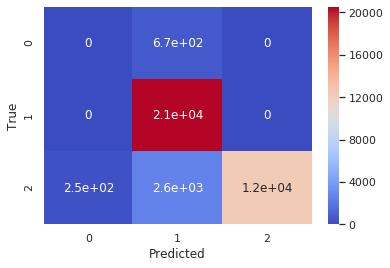

time: 267 ms


In [0]:
sns.heatmap(cmpp3hyp2_03,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

In [0]:
reportpp3hyp2_03 = classification_report(target_system, sc1pp3labelshyp2_03,output_dict = True)

time: 40.9 ms


In [0]:
reportpp3hyp2_03

{'1': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 671},
 '2': {'f1-score': 0.9258908434821831,
  'precision': 0.8620081468105657,
  'recall': 1.0,
  'support': 20527},
 '3': {'f1-score': 0.895594183885427,
  'precision': 1.0,
  'recall': 0.8109285290041576,
  'support': 15153},
 'accuracy': 0.9027261973535804,
 'macro avg': {'f1-score': 0.6071616757892033,
  'precision': 0.6206693822701886,
  'recall': 0.6036428430013858,
  'support': 36351},
 'weighted avg': {'f1-score': 0.8961706696535073,
  'precision': 0.9036186412913119,
  'recall': 0.9027261973535804,
  'support': 36351}}

time: 4.35 ms


In [0]:
print("Confusion matrix\n",metrics.confusion_matrix(y_true=target_system.System,y_pred=sc1pp3labelshyp2_03)) 
print("Classification report\n",metrics.classification_report(y_true=target_system.System,y_pred=sc1pp3labelshyp2_03))

Confusion matrix
 [[    0   671     0]
 [    0 20527     0]
 [  250  2615 12288]]
Classification report
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       671
           2       0.86      1.00      0.93     20527
           3       1.00      0.81      0.90     15153

    accuracy                           0.90     36351
   macro avg       0.62      0.60      0.61     36351
weighted avg       0.90      0.90      0.90     36351

time: 72.7 ms


In [0]:
print('\033[1m'+"Kmeans++:"+'\033[0m')
print('\033[1m'+"System 1"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp2_03["1"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp2_03["1"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp2_03["1"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp2_03["1"]["support"]))
print('\033[1m'+"System 2"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp2_03["2"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp2_03["2"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp2_03["2"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp2_03["2"]["support"]))
print('\033[1m'+"System 3"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp2_03["3"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp2_03["3"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp2_03["3"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp2_03["3"]["support"]))

Kmeans++:
System 1
Precision = 0.000
Recall = 0.000
F1-score = 0.000
Support = 671.000
System 2
Precision = 0.862
Recall = 1.000
F1-score = 0.926
Support = 20527.000
System 3
Precision = 1.000
Recall = 0.811
F1-score = 0.896
Support = 15153.000
time: 16.6 ms


In [0]:
print('\033[1m'+'Clustering metrics - supervised'+'\033[0m')
print('Adjusted Rand score: ', metrics.adjusted_rand_score(target_system.System, sc1pp3labelshyp2_03))
print('Mutual info score: ', metrics.adjusted_mutual_info_score(target_system.System, sc1pp3labelshyp2_03))
print('Homogeneity score: ', metrics.homogeneity_score(target_system.System, sc1pp3labelshyp2_03))
print('Completeness score: ', metrics.completeness_score(target_system.System, sc1pp3labelshyp2_03))
print('V-measure: ', metrics.v_measure_score(target_system.System, sc1pp3labelshyp2_03))
print('Fowlkes-Mallows score: ', metrics.fowlkes_mallows_score(target_system.System, sc1pp3labelshyp2_03))

Clustering metrics - supervised
Adjusted Rand score:  0.6823361077431518
Mutual info score:  0.6288415438002335
Homogeneity score:  0.5945082951466247
Completeness score:  0.6674481883802669
V-measure:  0.6288703132831919
Fowlkes-Mallows score:  0.8475658942266868
time: 59.5 ms


In [0]:
print('\033[1m'+'Clustering metrics - unsupervised'+'\033[0m')
print('Silhouette: ',metrics.silhouette_score(dfsc1, sc1pp3labelshyp2_03, metric='euclidean'))
print('Davies-Bouldin Index: ',metrics.davies_bouldin_score(dfsc1, sc1pp3labelshyp2_03))
print('Calinski-Harabasz Index: ',metrics.calinski_harabaz_score(dfsc1, sc1pp3labelshyp2_03))

Clustering metrics - unsupervised
Silhouette:  0.7084899313103125
Davies-Bouldin Index:  0.35351468150384296
Calinski-Harabasz Index:  40095.43389737366
time: 19 s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)


## Hyperparameter analysis: tol

### 3 scenarios: 0.001, 0.01, 0.1

### 01 - tol = 0.001

In [0]:
kmeansc1pp3hyp3_01 = KMeans(n_clusters=3, random_state=42, tol=0.001).fit(dfsc1)

time: 175 ms


In [0]:
kmeansc1pp3hyp3_01.labels_

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

time: 9.47 ms


In [0]:
sc1pp3labelshyp3_01 = pd.Series(kmeansc1pp3hyp3_01.labels_)

time: 2.78 ms


In [0]:
sc1pp3labelshyp3_01.value_counts()

0    23813
1    12288
2      250
dtype: int64

time: 16.2 ms


In [0]:
cmpp3hyp3_01 = confusion_matrix(target_system.System, sc1pp3labelshyp3_01)

time: 57.9 ms


In [0]:
cmpp3hyp3_01

array([[    0,     0,     0,     0],
       [  671,     0,     0,     0],
       [20527,     0,     0,     0],
       [ 2615, 12288,   250,     0]])

time: 5.1 ms


## Check correct labels

Text(30.5, 0.5, 'True')

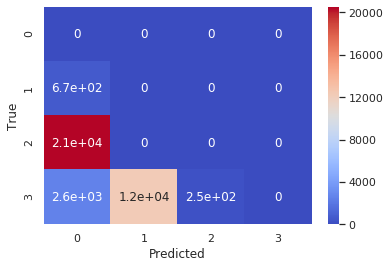

time: 319 ms


In [0]:
sns.heatmap(cmpp3hyp3_01,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

## Change to correct labels

In [0]:
sc1pp3labelshyp3_01
sc1pp3labelshyp3_01[sc1pp3labelshyp3_01 == 0] = 4
sc1pp3labelshyp3_01[sc1pp3labelshyp3_01 == 1] = 5
sc1pp3labelshyp3_01[sc1pp3labelshyp3_01 == 2] = 6

time: 15.4 ms


In [0]:
sc1pp3labelshyp3_01[sc1pp3labelshyp3_01 == 4] = 2
sc1pp3labelshyp3_01[sc1pp3labelshyp3_01 == 5] = 3
sc1pp3labelshyp3_01[sc1pp3labelshyp3_01 == 6] = 1

time: 14.9 ms


## Check heatmap

In [0]:
cmpp3hyp3_01 = confusion_matrix(target_system.System, sc1pp3labelshyp3_01)

time: 41 ms


In [0]:
cmpp3hyp3_01

array([[    0,   671,     0],
       [    0, 20527,     0],
       [  250,  2615, 12288]])

time: 3.74 ms


Text(30.5, 0.5, 'True')

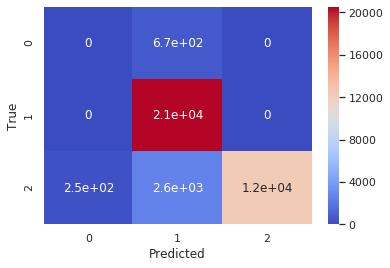

time: 289 ms


In [0]:
sns.heatmap(cmpp3hyp3_01,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

In [0]:
reportpp3hyp3_01 = classification_report(target_system, sc1pp3labelshyp3_01,output_dict = True)

time: 43 ms


In [0]:
reportpp3hyp3_01

{'1': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 671},
 '2': {'f1-score': 0.9258908434821831,
  'precision': 0.8620081468105657,
  'recall': 1.0,
  'support': 20527},
 '3': {'f1-score': 0.895594183885427,
  'precision': 1.0,
  'recall': 0.8109285290041576,
  'support': 15153},
 'accuracy': 0.9027261973535804,
 'macro avg': {'f1-score': 0.6071616757892033,
  'precision': 0.6206693822701886,
  'recall': 0.6036428430013858,
  'support': 36351},
 'weighted avg': {'f1-score': 0.8961706696535073,
  'precision': 0.9036186412913119,
  'recall': 0.9027261973535804,
  'support': 36351}}

time: 4.88 ms


In [0]:
print("Confusion matrix\n",metrics.confusion_matrix(y_true=target_system.System,y_pred=sc1pp3labelshyp3_01)) 
print("Classification report\n",metrics.classification_report(y_true=target_system.System,y_pred=sc1pp3labelshyp3_01))

Confusion matrix
 [[    0   671     0]
 [    0 20527     0]
 [  250  2615 12288]]
Classification report
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       671
           2       0.86      1.00      0.93     20527
           3       1.00      0.81      0.90     15153

    accuracy                           0.90     36351
   macro avg       0.62      0.60      0.61     36351
weighted avg       0.90      0.90      0.90     36351

time: 81 ms


In [0]:
print('\033[1m'+"Kmeans++:"+'\033[0m')
print('\033[1m'+"System 1"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp3_01["1"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp3_01["1"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp3_01["1"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp3_01["1"]["support"]))
print('\033[1m'+"System 2"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp3_01["2"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp3_01["2"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp3_01["2"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp3_01["2"]["support"]))
print('\033[1m'+"System 3"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp3_01["3"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp3_01["3"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp3_01["3"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp3_01["3"]["support"]))

Kmeans++:
System 1
Precision = 0.000
Recall = 0.000
F1-score = 0.000
Support = 671.000
System 2
Precision = 0.862
Recall = 1.000
F1-score = 0.926
Support = 20527.000
System 3
Precision = 1.000
Recall = 0.811
F1-score = 0.896
Support = 15153.000
time: 22.7 ms


In [0]:
print('\033[1m'+'Clustering metrics - supervised'+'\033[0m')
print('Adjusted Rand score: ', metrics.adjusted_rand_score(target_system.System, sc1pp3labelshyp3_01))
print('Mutual info score: ', metrics.adjusted_mutual_info_score(target_system.System, sc1pp3labelshyp3_01))
print('Homogeneity score: ', metrics.homogeneity_score(target_system.System, sc1pp3labelshyp3_01))
print('Completeness score: ', metrics.completeness_score(target_system.System, sc1pp3labelshyp3_01))
print('V-measure: ', metrics.v_measure_score(target_system.System, sc1pp3labelshyp3_01))
print('Fowlkes-Mallows score: ', metrics.fowlkes_mallows_score(target_system.System, sc1pp3labelshyp3_01))

Clustering metrics - supervised
Adjusted Rand score:  0.6823361077431518
Mutual info score:  0.6288415438002335
Homogeneity score:  0.5945082951466247
Completeness score:  0.6674481883802669
V-measure:  0.6288703132831919
Fowlkes-Mallows score:  0.8475658942266868
time: 61 ms


In [0]:
print('\033[1m'+'Clustering metrics - unsupervised'+'\033[0m')
print('Silhouette: ',metrics.silhouette_score(dfsc1, sc1pp3labelshyp3_01, metric='euclidean'))
print('Davies-Bouldin Index: ',metrics.davies_bouldin_score(dfsc1, sc1pp3labelshyp3_01))
print('Calinski-Harabasz Index: ',metrics.calinski_harabaz_score(dfsc1, sc1pp3labelshyp3_01))

Clustering metrics - unsupervised
Silhouette:  0.7084899313103125
Davies-Bouldin Index:  0.35351468150384296
Calinski-Harabasz Index:  40095.43389737366
time: 19.5 s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)


### 02 - tol = 0.01

In [0]:
kmeansc1pp3hyp3_02 = KMeans(n_clusters=3, random_state=42, tol=0.01).fit(dfsc1)

time: 163 ms


In [0]:
kmeansc1pp3hyp3_02.labels_

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

time: 5 ms


In [0]:
sc1pp3labelshyp3_02 = pd.Series(kmeansc1pp3hyp3_02.labels_)

time: 1.49 ms


In [0]:
sc1pp3labelshyp3_02.value_counts()

0    23813
1    12288
2      250
dtype: int64

time: 17.4 ms


In [0]:
cmpp3hyp3_02 = confusion_matrix(target_system.System, sc1pp3labelshyp3_02)

time: 74 ms


In [0]:
cmpp3hyp3_02

array([[    0,     0,     0,     0],
       [  671,     0,     0,     0],
       [20527,     0,     0,     0],
       [ 2615, 12288,   250,     0]])

time: 5.78 ms


## Check correct labels

Text(30.5, 0.5, 'True')

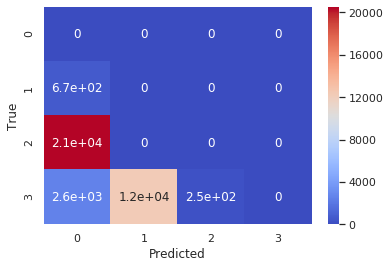

time: 308 ms


In [0]:
sns.heatmap(cmpp3hyp3_02,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

## Change to correct labels

In [0]:
sc1pp3labelshyp3_02
sc1pp3labelshyp3_02[sc1pp3labelshyp3_02 == 0] = 4
sc1pp3labelshyp3_02[sc1pp3labelshyp3_02 == 1] = 5
sc1pp3labelshyp3_02[sc1pp3labelshyp3_02 == 2] = 6

time: 12.6 ms


In [0]:
sc1pp3labelshyp3_02[sc1pp3labelshyp3_02 == 4] = 2
sc1pp3labelshyp3_02[sc1pp3labelshyp3_02 == 5] = 3
sc1pp3labelshyp3_02[sc1pp3labelshyp3_02 == 6] = 1

time: 14.6 ms


## Check heatmap

In [0]:
cmpp3hyp3_02 = confusion_matrix(target_system.System, sc1pp3labelshyp3_02)

time: 40.6 ms


In [0]:
cmpp3hyp3_02

array([[    0,   671,     0],
       [    0, 20527,     0],
       [  250,  2615, 12288]])

time: 3.91 ms


Text(30.5, 0.5, 'True')

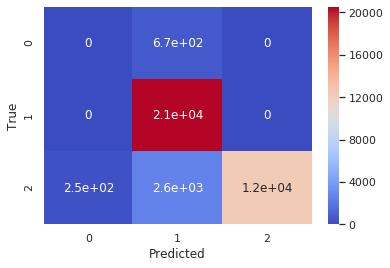

time: 293 ms


In [0]:
sns.heatmap(cmpp3hyp3_02,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

In [0]:
reportpp3hyp3_02 = classification_report(target_system, sc1pp3labelshyp3_02,output_dict = True)

time: 37.5 ms


In [0]:
reportpp3hyp3_02

{'1': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 671},
 '2': {'f1-score': 0.9258908434821831,
  'precision': 0.8620081468105657,
  'recall': 1.0,
  'support': 20527},
 '3': {'f1-score': 0.895594183885427,
  'precision': 1.0,
  'recall': 0.8109285290041576,
  'support': 15153},
 'accuracy': 0.9027261973535804,
 'macro avg': {'f1-score': 0.6071616757892033,
  'precision': 0.6206693822701886,
  'recall': 0.6036428430013858,
  'support': 36351},
 'weighted avg': {'f1-score': 0.8961706696535073,
  'precision': 0.9036186412913119,
  'recall': 0.9027261973535804,
  'support': 36351}}

time: 6.09 ms


In [0]:
print("Confusion matrix\n",metrics.confusion_matrix(y_true=target_system.System,y_pred=sc1pp3labelshyp3_02)) 
print("Classification report\n",metrics.classification_report(y_true=target_system.System,y_pred=sc1pp3labelshyp3_02))

Confusion matrix
 [[    0   671     0]
 [    0 20527     0]
 [  250  2615 12288]]
Classification report
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       671
           2       0.86      1.00      0.93     20527
           3       1.00      0.81      0.90     15153

    accuracy                           0.90     36351
   macro avg       0.62      0.60      0.61     36351
weighted avg       0.90      0.90      0.90     36351

time: 80.8 ms


In [0]:
print('\033[1m'+"Kmeans++:"+'\033[0m')
print('\033[1m'+"System 1"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp3_02["1"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp3_02["1"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp3_02["1"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp3_02["1"]["support"]))
print('\033[1m'+"System 2"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp3_02["2"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp3_02["2"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp3_02["2"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp3_02["2"]["support"]))
print('\033[1m'+"System 3"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp3_02["3"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp3_02["3"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp3_02["3"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp3_02["3"]["support"]))

Kmeans++:
System 1
Precision = 0.000
Recall = 0.000
F1-score = 0.000
Support = 671.000
System 2
Precision = 0.862
Recall = 1.000
F1-score = 0.926
Support = 20527.000
System 3
Precision = 1.000
Recall = 0.811
F1-score = 0.896
Support = 15153.000
time: 20.2 ms


In [0]:
print('\033[1m'+'Clustering metrics - supervised'+'\033[0m')
print('Adjusted Rand score: ', metrics.adjusted_rand_score(target_system.System, sc1pp3labelshyp3_02))
print('Mutual info score: ', metrics.adjusted_mutual_info_score(target_system.System, sc1pp3labelshyp3_02))
print('Homogeneity score: ', metrics.homogeneity_score(target_system.System, sc1pp3labelshyp3_02))
print('Completeness score: ', metrics.completeness_score(target_system.System, sc1pp3labelshyp3_02))
print('V-measure: ', metrics.v_measure_score(target_system.System, sc1pp3labelshyp3_02))
print('Fowlkes-Mallows score: ', metrics.fowlkes_mallows_score(target_system.System, sc1pp3labelshyp3_02))

Clustering metrics - supervised
Adjusted Rand score:  0.6823361077431518
Mutual info score:  0.6288415438002335
Homogeneity score:  0.5945082951466247
Completeness score:  0.6674481883802669
V-measure:  0.6288703132831919
Fowlkes-Mallows score:  0.8475658942266868
time: 65.1 ms


In [0]:
print('\033[1m'+'Clustering metrics - unsupervised'+'\033[0m')
print('Silhouette: ',metrics.silhouette_score(dfsc1, sc1pp3labelshyp3_02, metric='euclidean'))
print('Davies-Bouldin Index: ',metrics.davies_bouldin_score(dfsc1, sc1pp3labelshyp3_02))
print('Calinski-Harabasz Index: ',metrics.calinski_harabaz_score(dfsc1, sc1pp3labelshyp3_02))

Clustering metrics - unsupervised
Silhouette:  0.7084899313103125
Davies-Bouldin Index:  0.35351468150384296
Calinski-Harabasz Index:  40095.43389737366
time: 19.4 s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)


### 03 - tol = 0.1

In [0]:
kmeansc1pp3hyp3_03 = KMeans(n_clusters=3, random_state=42, tol=0.1).fit(dfsc1)

time: 160 ms


In [0]:
kmeansc1pp3hyp3_03.labels_

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

time: 3.52 ms


In [0]:
sc1pp3labelshyp3_03 = pd.Series(kmeansc1pp3hyp3_03.labels_)

time: 1.47 ms


In [0]:
sc1pp3labelshyp3_03.value_counts()

0    23813
1    12288
2      250
dtype: int64

time: 8.27 ms


In [0]:
cmpp3hyp3_03 = confusion_matrix(target_system.System, sc1pp3labelshyp3_03)

time: 77.5 ms


In [0]:
cmpp3hyp3_03

array([[    0,     0,     0,     0],
       [  671,     0,     0,     0],
       [20527,     0,     0,     0],
       [ 2615, 12288,   250,     0]])

time: 5.25 ms


## Check correct labels

Text(30.5, 0.5, 'True')

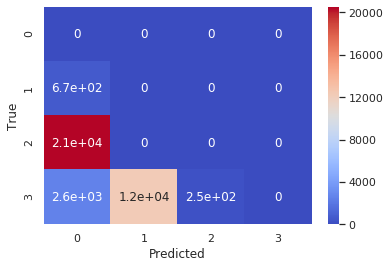

time: 299 ms


In [0]:
sns.heatmap(cmpp3hyp3_03,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

## Change to correct labels

In [0]:
sc1pp3labelshyp3_03
sc1pp3labelshyp3_03[sc1pp3labelshyp3_03 == 0] = 4
sc1pp3labelshyp3_03[sc1pp3labelshyp3_03 == 1] = 5
sc1pp3labelshyp3_03[sc1pp3labelshyp3_03 == 2] = 6

time: 14.5 ms


In [0]:
sc1pp3labelshyp3_03[sc1pp3labelshyp3_03 == 4] = 2
sc1pp3labelshyp3_03[sc1pp3labelshyp3_03 == 5] = 3
sc1pp3labelshyp3_03[sc1pp3labelshyp3_03 == 6] = 1

time: 14.8 ms


## Check heatmap

In [0]:
cmpp3hyp3_03 = confusion_matrix(target_system.System, sc1pp3labelshyp3_03)

time: 36.9 ms


In [0]:
cmpp3hyp3_03

array([[    0,   671,     0],
       [    0, 20527,     0],
       [  250,  2615, 12288]])

time: 4.84 ms


Text(30.5, 0.5, 'True')

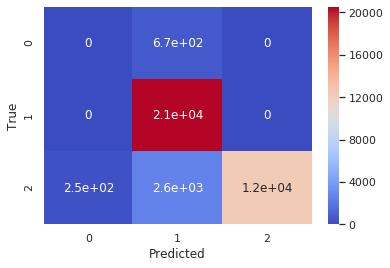

time: 408 ms


In [0]:
sns.heatmap(cmpp3hyp3_03,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

In [0]:
reportpp3hyp3_03 = classification_report(target_system, sc1pp3labelshyp3_03,output_dict = True)

time: 38.8 ms


In [0]:
reportpp3hyp3_03

{'1': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 671},
 '2': {'f1-score': 0.9258908434821831,
  'precision': 0.8620081468105657,
  'recall': 1.0,
  'support': 20527},
 '3': {'f1-score': 0.895594183885427,
  'precision': 1.0,
  'recall': 0.8109285290041576,
  'support': 15153},
 'accuracy': 0.9027261973535804,
 'macro avg': {'f1-score': 0.6071616757892033,
  'precision': 0.6206693822701886,
  'recall': 0.6036428430013858,
  'support': 36351},
 'weighted avg': {'f1-score': 0.8961706696535073,
  'precision': 0.9036186412913119,
  'recall': 0.9027261973535804,
  'support': 36351}}

time: 5.53 ms


In [0]:
print("Confusion matrix\n",metrics.confusion_matrix(y_true=target_system.System,y_pred=sc1pp3labelshyp3_03)) 
print("Classification report\n",metrics.classification_report(y_true=target_system.System,y_pred=sc1pp3labelshyp3_03))

Confusion matrix
 [[    0   671     0]
 [    0 20527     0]
 [  250  2615 12288]]
Classification report
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       671
           2       0.86      1.00      0.93     20527
           3       1.00      0.81      0.90     15153

    accuracy                           0.90     36351
   macro avg       0.62      0.60      0.61     36351
weighted avg       0.90      0.90      0.90     36351

time: 82.5 ms


In [0]:
print('\033[1m'+"Kmeans++:"+'\033[0m')
print('\033[1m'+"System 1"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp3_03["1"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp3_03["1"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp3_03["1"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp3_03["1"]["support"]))
print('\033[1m'+"System 2"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp3_03["2"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp3_03["2"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp3_03["2"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp3_03["2"]["support"]))
print('\033[1m'+"System 3"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp3_03["3"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp3_03["3"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp3_03["3"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp3_03["3"]["support"]))

Kmeans++:
System 1
Precision = 0.000
Recall = 0.000
F1-score = 0.000
Support = 671.000
System 2
Precision = 0.862
Recall = 1.000
F1-score = 0.926
Support = 20527.000
System 3
Precision = 1.000
Recall = 0.811
F1-score = 0.896
Support = 15153.000
time: 19.5 ms


In [0]:
print('\033[1m'+'Clustering metrics - supervised'+'\033[0m')
print('Adjusted Rand score: ', metrics.adjusted_rand_score(target_system.System, sc1pp3labelshyp3_03))
print('Mutual info score: ', metrics.adjusted_mutual_info_score(target_system.System, sc1pp3labelshyp3_03))
print('Homogeneity score: ', metrics.homogeneity_score(target_system.System, sc1pp3labelshyp3_03))
print('Completeness score: ', metrics.completeness_score(target_system.System, sc1pp3labelshyp3_03))
print('V-measure: ', metrics.v_measure_score(target_system.System, sc1pp3labelshyp3_03))
print('Fowlkes-Mallows score: ', metrics.fowlkes_mallows_score(target_system.System, sc1pp3labelshyp3_03))

Clustering metrics - supervised
Adjusted Rand score:  0.6823361077431518
Mutual info score:  0.6288415438002335
Homogeneity score:  0.5945082951466247
Completeness score:  0.6674481883802669
V-measure:  0.6288703132831919
Fowlkes-Mallows score:  0.8475658942266868
time: 64.1 ms


In [0]:
print('\033[1m'+'Clustering metrics - unsupervised'+'\033[0m')
print('Silhouette: ',metrics.silhouette_score(dfsc1, sc1pp3labelshyp3_03, metric='euclidean'))
print('Davies-Bouldin Index: ',metrics.davies_bouldin_score(dfsc1, sc1pp3labelshyp3_03))
print('Calinski-Harabasz Index: ',metrics.calinski_harabaz_score(dfsc1, sc1pp3labelshyp3_03))

Clustering metrics - unsupervised
Silhouette:  0.7084899313103125
Davies-Bouldin Index:  0.35351468150384296
Calinski-Harabasz Index:  40095.43389737366
time: 19.3 s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)


# 4 Visualize data with PCA

Source: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

In [0]:
reduced_data = PCA(n_components=2).fit_transform(dfsc1)
kmeans = KMeans(init='k-means++', n_clusters=3, n_init=100)
kmeans.fit(reduced_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=100, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

time: 1.59 s


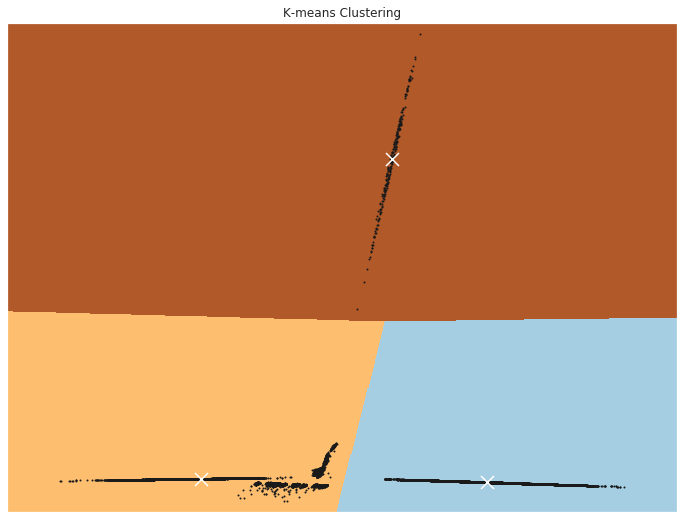

time: 502 ms


In [0]:
h = .02


x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)

plt.figure(figsize = (12,9))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)

centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)


plt.title('K-means Clustering')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()